In [1]:
import math, random, pathlib, csv, time, itertools, json, argparse
from collections import defaultdict

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, random_split
from torchvision import datasets, transforms
from sklearn.metrics import precision_recall_fscore_support, accuracy_score


from functools import lru_cache
@lru_cache(maxsize=128)
def compute_scaled_legendre_polynomials(x: torch.Tensor, order: int) -> torch.Tensor:
    t = 2.0 * x - 1.0
    P0 = torch.ones_like(t)
    if order == 0:
        return P0[..., None]
    P1 = t
    P = [P0, P1]
    for n in range(1, order):
        P_next = ((2.0 * n + 1.0) * t * P[-1] - n * P[-2]) / (n + 1.0)
        P.append(P_next)
    P = torch.stack(P, dim=-1)
    degrees = torch.arange(order + 1, device=x.device, dtype=x.dtype)
    scale = torch.sqrt(2.0 * degrees + 1.0)
    return P * scale



class KAL_Layer(nn.Module):
    def __init__(self, in_f, out_f, degree, act=nn.SiLU):
        #original code
        super().__init__()
        self.act = act()
        self.degree = degree

        self.base_w = nn.Parameter(torch.empty(out_f, in_f))
        self.poly_w = nn.Parameter(torch.empty(out_f, in_f * (degree + 1)))

        self.ln = nn.LayerNorm(out_f)

        #initialize paarams
        nn.init.kaiming_uniform_(self.base_w, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.poly_w, a=math.sqrt(5))

    def forward(self, x):
        z = self.act(F.linear(x, self.base_w))
        x_n = (x - x.min()) / (x.max() - x.min())
        P = compute_scaled_legendre_polynomials(x_n, self.degree).view(x.size(0), -1)
        z += F.linear(P, self.poly_w)
        return self.act(self.ln(z))


class CDFKAL_Layer(nn.Module):
    def __init__(self, in_f, out_f, degree):
        super().__init__()
        self.degree = degree
        self.poly_w = nn.Parameter(torch.empty(out_f, in_f * (degree + 1)))
        nn.init.kaiming_uniform_(self.poly_w, a=math.sqrt(5))

    def forward(self, x):
        u = 0.5 * (1 + torch.erf(x / math.sqrt(2)))
        P = compute_scaled_legendre_polynomials(u, self.degree).view(x.size(0), -1)
        return F.linear(P, self.poly_w)

class CDFKAL_SILU_Layer(nn.Module):
    def __init__(self, in_f, out_f, degree, act=nn.SiLU):
        super().__init__()
        self.act = act()
        self.degree = degree

        self.base_w = nn.Parameter(torch.empty(out_f, in_f))
        self.poly_w = nn.Parameter(torch.empty(out_f, in_f * (degree + 1)))

        #initialize paarams
        nn.init.kaiming_uniform_(self.poly_w, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.base_w, a=math.sqrt(5))

    def forward(self, x):
        z = self.act(F.linear(x, self.base_w))
        u = 0.5 * (1 + torch.erf(x / math.sqrt(2)))
        P = compute_scaled_legendre_polynomials(u, self.degree).view(x.size(0), -1)
        z += F.linear(P, self.poly_w)
        return self.act(z)

class KAL_NET(nn.Module):
    "This is original Legendre Kan Implementation with minmax scaling and silu activation"
    def __init__(self, degree):
        super().__init__()
        self.l1  = KAL_Layer(28*28, 256, degree)
        self.l2  = KAL_Layer(256, 256, degree)
        self.l3  = KAL_Layer(256, 10,  degree)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.l1(x)
        x = self.l2(x)
        return self.l3(x)

class CDFKAL_NET_FIXEDNORM(nn.Module):
    "This is CDF-Normalized KAN with Legendre Basis but without learnable beta and gamma in the LayerNorm without SILU"
    def __init__(self, degree):
        super().__init__()
        self.ln0 = nn.LayerNorm(28*28,elementwise_affine=False)
        self.l1  = CDFKAL_Layer(28*28, 256, degree)
        self.ln1 = nn.LayerNorm(256, elementwise_affine=False)
        self.l2  = CDFKAL_Layer(256, 256, degree)
        self.ln2 = nn.LayerNorm(256, elementwise_affine=False)
        self.l3  = CDFKAL_Layer(256, 10,  degree)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.ln0(x)
        x = self.l1(x)
        x = self.ln1(x)
        x = self.l2(x)
        x = self.ln2(x)
        return self.l3(x)

class CDFKAL_NET(nn.Module):
    "This is CDF-Normalized KAN with Legendre Basis with learnable beta and gamma in the LayerNorm without SILU"
    def __init__(self, degree):
        super().__init__()
        self.ln0 = nn.LayerNorm(28*28)
        self.l1  = CDFKAL_Layer(28*28, 256, degree)
        self.ln1 = nn.LayerNorm(256)
        self.l2  = CDFKAL_Layer(256, 256, degree)
        self.ln2 = nn.LayerNorm(256)
        self.l3  = CDFKAL_Layer(256, 10,  degree)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.ln0(x)
        x = self.l1(x)
        x = self.ln1(x)
        x = self.l2(x)
        x = self.ln2(x)
        return self.l3(x)

class CDFKAL_NET_SILU(nn.Module):
    "This is CDF-Normalized KAN with Legendre Basis with learnable beta and gamma in the LayerNorm with Silu"
    def __init__(self, degree):
        super().__init__()
        self.ln0 = nn.LayerNorm(28*28)
        self.l1  = CDFKAL_SILU_Layer(28*28, 256, degree)
        self.ln1 = nn.LayerNorm(256)
        self.l2  = CDFKAL_SILU_Layer(256, 256, degree)
        self.ln2 = nn.LayerNorm(256)
        self.l3  = CDFKAL_SILU_Layer(256, 10,  degree)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.ln0(x)
        x = self.l1(x)
        x = self.ln1(x)
        x = self.l2(x)
        x = self.ln2(x)
        return self.l3(x)

Running on cuda

=== CDFKAL_NET_SILU (degree 3) ===
Epoch 1/20: train_acc=0.3009 test_acc=0.3062 train_loss=1.7930 test_loss=1.7920 train_f1=0.2087 test_f1=0.2108 time=10.6s
Epoch 2/20: train_acc=0.7026 test_acc=0.6994 train_loss=1.7282 test_loss=1.7324 train_f1=0.6877 test_f1=0.6860 time=9.3s
Epoch 3/20: train_acc=0.7333 test_acc=0.7400 train_loss=1.6966 test_loss=1.7005 train_f1=0.7295 test_f1=0.7373 time=8.9s
Epoch 4/20: train_acc=0.7873 test_acc=0.7863 train_loss=1.6858 test_loss=1.6915 train_f1=0.7852 test_f1=0.7856 time=7.0s
Epoch 5/20: train_acc=0.8202 test_acc=0.8078 train_loss=1.6705 test_loss=1.6888 train_f1=0.8121 test_f1=0.8012 time=6.2s
Epoch 6/20: train_acc=0.8243 test_acc=0.8131 train_loss=1.6606 test_loss=1.6724 train_f1=0.8097 test_f1=0.8009 time=7.1s
Epoch 7/20: train_acc=0.8792 test_acc=0.8708 train_loss=1.6620 test_loss=1.6791 train_f1=0.8772 test_f1=0.8697 time=6.1s
Epoch 8/20: train_acc=0.9014 test_acc=0.8909 train_loss=1.6512 test_loss=1.6710 train_f1=0.8990 test

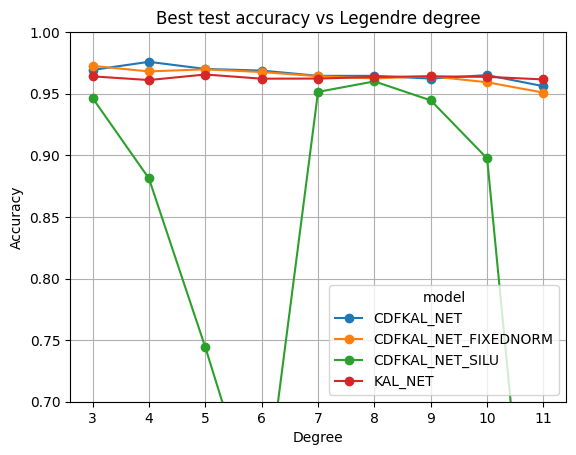

In [ ]:
import random
import time
import gc

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset

from torchvision import transforms, datasets

import pandas as pd
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on", device)

random.seed(42)
torch.manual_seed(42)
degrees = range(3, 12)
EPOCHS = 20
LR = 1e-3


#---------------------------------------------------------------



def evaluate(model: nn.Module, loader: DataLoader, criterion: nn.Module):
    """Return accuracy, macro‑F1, and average loss on `loader`."""
    model.eval()
    correct, total = 0, 0
    y_true, y_pred = [], []
    running_loss = 0.0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            running_loss += loss.item() * target.size(0)
            pred = output.argmax(dim=1)
            correct += (pred == target).sum().item()
            total += target.numel()
            y_true.extend(target.tolist())
            y_pred.extend(pred.tolist())
    acc = correct / total
    f1 = f1_score(y_true, y_pred, average="macro")
    avg_loss = running_loss / total
    return acc, f1, avg_loss


def train(
    model: nn.Module,
    train_loader: DataLoader,
    test_loader: DataLoader,
    logs: list[dict],          # list that will receive per‑epoch metric dicts
    run_info: dict,            # e.g. {"model": "KAL_NET", "degree": 4}
    *,
    epochs: int = 2,
    lr: float = 1e-3,
):
    """Train `model` for `epochs` epochs, logging a rich set of metrics."""

    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    ce = nn.CrossEntropyLoss()

    history = {
        "train_acc": [],
        "test_acc":  [],
        "train_loss": [],
        "test_loss":  [],
        "train_f1":   [],
        "test_f1":    [],
        "epoch_time": [],
    }

    for epoch in range(epochs):
        start_t = time.time()
        model.train()
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            opt.zero_grad(set_to_none=True)
            ce(model(data), target).backward()
            opt.step()

        tr_acc, tr_f1, tr_loss = evaluate(model, train_loader, ce)
        te_acc, te_f1, te_loss = evaluate(model, test_loader, ce)
        duration = time.time() - start_t

        history["train_acc"].append(tr_acc)
        history["test_acc"].append(te_acc)
        history["train_loss"].append(tr_loss)
        history["test_loss"].append(te_loss)
        history["train_f1"].append(tr_f1)
        history["test_f1"].append(te_f1)
        history["epoch_time"].append(duration)

        logs.append(
            {
                **run_info,
                "epoch": epoch + 1,
                "train_acc": tr_acc,
                "test_acc": te_acc,
                "train_loss": tr_loss,
                "test_loss": te_loss,
                "train_f1": tr_f1,
                "test_f1": te_f1,
                "epoch_time": duration,
            }
        )

        print(
            f"Epoch {epoch + 1}/{epochs}: "
            f"train_acc={tr_acc:.4f} test_acc={te_acc:.4f} "
            f"train_loss={tr_loss:.4f} test_loss={te_loss:.4f} "
            f"train_f1={tr_f1:.4f} test_f1={te_f1:.4f} "
            f"time={duration:.1f}s"
        )

    return history


transform = transforms.ToTensor()
train_full = datasets.MNIST(
    root="./data", train=True, transform=transform, download=True
)
subset_size = 20000
subset_idx = torch.randperm(len(train_full))[:subset_size]
train_ds = Subset(train_full, subset_idx)

test_ds = datasets.MNIST(
    root="./data", train=False, transform=transform, download=True
)

batch_size = 128
train_loader = DataLoader(
    train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True
)

test_loader = DataLoader(
    test_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True
)

model_specs = [
    ("CDFKAL_NET_SILU", CDFKAL_NET_SILU),
    ("CDFKAL_NET", CDFKAL_NET),
    ("CDFKAL_NET_FIXEDNORM", CDFKAL_NET_FIXEDNORM),
    ("KAL_NET", KAL_NET)
]



metrics_logs: list[dict] = []
results_summary = []

for deg in degrees:
    for name, Net in model_specs:
        print(f"\n=== {name} (degree {deg}) ===")
        model = Net(deg)
        history = train(
            model,
            train_loader,
            test_loader,
            logs=metrics_logs,
            run_info={"model": name, "degree": deg},
            epochs=EPOCHS,
            lr=LR,
        )

        best_idx = max(range(EPOCHS), key=lambda i: history["test_acc"][i])
        results_summary.append(
            {
                "model": name,
                "degree": deg,
                "best_epoch": best_idx + 1,
                "best_test_acc": history["test_acc"][best_idx],
                "best_test_f1": history["test_f1"][best_idx],
            }
        )

        del model
        torch.cuda.empty_cache()
        gc.collect()



metrics_df = pd.DataFrame(metrics_logs)
summary_df = pd.DataFrame(results_summary)

metrics_df.to_csv("metrics_full.csv", index=False)
summary_df.to_csv("results_summary.csv", index=False)

print("\n--- Summary (best per run) ---")
print(summary_df)


pivot_acc = summary_df.pivot(index="degree", columns="model", values="best_test_acc")

pivot_acc.plot(marker="o")
plt.title("Best test accuracy vs Legendre degree")
plt.ylabel("Accuracy")
plt.xlabel("Degree")
plt.ylim(0.7, 1.0)
plt.grid(True)
plt.show()

#We see that this Silu is not useful for CDF.
When i was looking at the code of the original Legendre KAN Implementation i saw that they used double silu activation. At the beginning of a layer and at the end. Ill quickly try to do a single silu

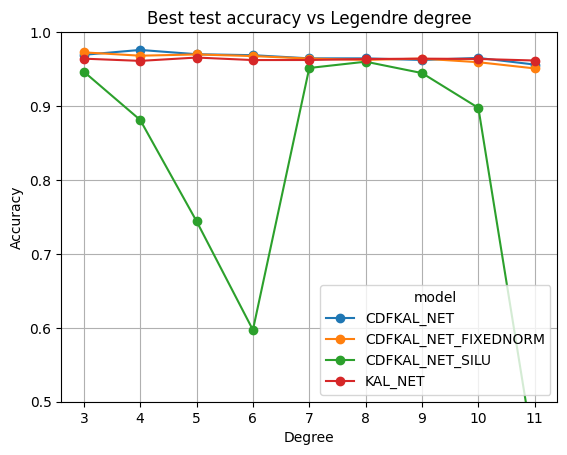

In [ ]:
pivot_acc.plot(marker="o")
plt.title("Best test accuracy vs Legendre degree")
plt.ylabel("Accuracy")
plt.xlabel("Degree")
plt.ylim(0.5, 1.0)
plt.grid(True)
plt.show()

In [4]:
import random
import time
import gc
import math

from torchvision import transforms, datasets

import pandas as pd
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt


import torch, torch.nn as nn, torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on", device)


#SINGLE SILU

class CDFKAL_SINGLE_SILU_Layer(nn.Module):
    def __init__(self, in_f, out_f, degree, act=nn.SiLU):
        super().__init__()
        self.act = act()
        self.degree = degree

        self.base_w = nn.Parameter(torch.empty(out_f, in_f))
        self.poly_w = nn.Parameter(torch.empty(out_f, in_f * (degree + 1)))

        #initialize paarams
        nn.init.kaiming_uniform_(self.poly_w, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.base_w, a=math.sqrt(5))

    def forward(self, x):
        z = self.act(F.linear(x, self.base_w)) #single silu activation
        u = 0.5 * (1 + torch.erf(x / math.sqrt(2)))
        P = compute_scaled_legendre_polynomials(u, self.degree).view(x.size(0), -1)
        z += F.linear(P, self.poly_w)
        return z

class CDFKAL_NET_SILU1(nn.Module):
    "This is CDF-Normalized KAN with Legendre Basis with learnable beta and gamma in the LayerNorm with Silu"
    def __init__(self, degree):
        super().__init__()
        self.ln0 = nn.LayerNorm(28*28)
        self.l1  = CDFKAL_SINGLE_SILU_Layer(28*28, 256, degree)
        self.ln1 = nn.LayerNorm(256)
        self.l2  = CDFKAL_SINGLE_SILU_Layer(256, 256, degree)
        self.ln2 = nn.LayerNorm(256)
        self.l3  = CDFKAL_SINGLE_SILU_Layer(256, 10,  degree)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.ln0(x)
        x = self.l1(x)
        x = self.ln1(x)
        x = self.l2(x)
        x = self.ln2(x)
        return self.l3(x)





random.seed(42)
torch.manual_seed(42)
degrees = range(3,12)
EPOCHS = 20
LR = 1e-3


#---------------------------------------------------------------



def evaluate(model: nn.Module, loader: DataLoader, criterion: nn.Module):
    """Return accuracy, macro‑F1, and average loss on `loader`."""
    model.eval()
    correct, total = 0, 0
    y_true, y_pred = [], []
    running_loss = 0.0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            running_loss += loss.item() * target.size(0)
            pred = output.argmax(dim=1)
            correct += (pred == target).sum().item()
            total += target.numel()
            y_true.extend(target.tolist())
            y_pred.extend(pred.tolist())
    acc = correct / total
    f1 = f1_score(y_true, y_pred, average="macro")
    avg_loss = running_loss / total
    return acc, f1, avg_loss


def train(
    model: nn.Module,
    train_loader: DataLoader,
    test_loader: DataLoader,
    logs: list[dict],          # list that will receive per‑epoch metric dicts
    run_info: dict,            # e.g. {"model": "KAL_NET", "degree": 4}
    *,
    epochs: int = 2,
    lr: float = 1e-3,
):
    """Train `model` for `epochs` epochs, logging a rich set of metrics."""

    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    ce = nn.CrossEntropyLoss()

    history = {
        "train_acc": [],
        "test_acc":  [],
        "train_loss": [],
        "test_loss":  [],
        "train_f1":   [],
        "test_f1":    [],
        "epoch_time": [],
    }

    for epoch in range(epochs):
        start_t = time.time()
        model.train()
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            opt.zero_grad(set_to_none=True)
            ce(model(data), target).backward()
            opt.step()

        tr_acc, tr_f1, tr_loss = evaluate(model, train_loader, ce)
        te_acc, te_f1, te_loss = evaluate(model, test_loader, ce)
        duration = time.time() - start_t

        history["train_acc"].append(tr_acc)
        history["test_acc"].append(te_acc)
        history["train_loss"].append(tr_loss)
        history["test_loss"].append(te_loss)
        history["train_f1"].append(tr_f1)
        history["test_f1"].append(te_f1)
        history["epoch_time"].append(duration)

        logs.append(
            {
                **run_info,
                "epoch": epoch + 1,
                "train_acc": tr_acc,
                "test_acc": te_acc,
                "train_loss": tr_loss,
                "test_loss": te_loss,
                "train_f1": tr_f1,
                "test_f1": te_f1,
                "epoch_time": duration,
            }
        )

        print(
            f"Epoch {epoch + 1}/{epochs}: "
            f"train_acc={tr_acc:.4f} test_acc={te_acc:.4f} "
            f"train_loss={tr_loss:.4f} test_loss={te_loss:.4f} "
            f"train_f1={tr_f1:.4f} test_f1={te_f1:.4f} "
            f"time={duration:.1f}s"
        )

    return history


transform = transforms.ToTensor()
train_full = datasets.MNIST(
    root="./data", train=True, transform=transform, download=True
)
subset_size = 20000
subset_idx = torch.randperm(len(train_full))[:subset_size]
train_ds = Subset(train_full, subset_idx)

test_ds = datasets.MNIST(
    root="./data", train=False, transform=transform, download=True
)

batch_size = 128
train_loader = DataLoader(
    train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True
)

test_loader = DataLoader(
    test_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True
)

model_specs = [
    ("CDFKAL_NET_SILU1", CDFKAL_NET_SILU1),

]


metrics_logs: list[dict] = []
results_summary = []

for deg in degrees:
    for name, Net in model_specs:
        print(f"\n=== {name} (degree {deg}) ===")
        model = Net(deg)
        history = train(
            model,
            train_loader,
            test_loader,
            logs=metrics_logs,
            run_info={"model": name, "degree": deg},
            epochs=EPOCHS,
            lr=LR,
        )

        best_idx = max(range(EPOCHS), key=lambda i: history["test_acc"][i])
        results_summary.append(
            {
                "model": name,
                "degree": deg,
                "best_epoch": best_idx + 1,
                "best_test_acc": history["test_acc"][best_idx],
                "best_test_f1": history["test_f1"][best_idx],
            }
        )

        del model
        torch.cuda.empty_cache()
        gc.collect()



metrics_df = pd.DataFrame(metrics_logs)
summary_df = pd.DataFrame(results_summary)

metrics_df.to_csv("metrics_full_silu.csv", index=False)
summary_df.to_csv("results_summary_silu.csv", index=False)

print("\n--- Summary (best per run) ---")
print(summary_df)


pivot_acc = summary_df.pivot(index="degree", columns="model", values="best_test_acc")

pivot_acc.plot(marker="o")
plt.title("Best test accuracy vs Legendre degree")
plt.ylabel("Accuracy")
plt.xlabel("Degree")
plt.ylim(0.7, 1.0)
plt.grid(True)
plt.show()

#Ok turns out single Silu activation fixed the issues. Ill load these metrics saved as csv to combine this new silu with the previous calculated metrics.
Ill also remove the double activation

In [12]:
# import pandas as pd
# import matplotlib.pyplot as plt
# metrics_with_silu = pd.read_csv("metrics_full_silu.csv")
# metrics_df = pd.read_csv("metrics_full.csv")
# combined = pd.concat([metrics_df, metrics_with_silu])
# combined_without_double_silu = combined[combined["model"] != "CDFKAL_NET_SILU"]
# combined_without_double_silu['model'] = combined_without_double_silu['model'].replace({
#     'CDFKAL_NET_SILU1': 'CDFKAL_SILU'
# })
# pivot_df = combined_without_double_silu.pivot_table(
#     index='degree',
#     columns='model',
#     values='test_acc',
#     aggfunc='max'
# )

/tmp/ipython-input-12-3135816894.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_without_double_silu['model'] = combined_without_double_silu['model'].replace({


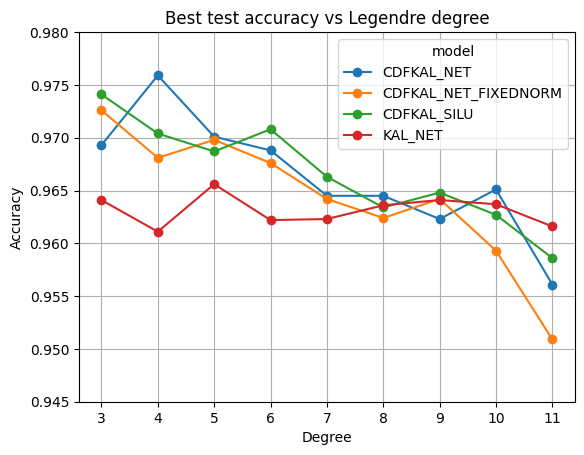

In [13]:
pivot_df.plot(marker="o")
plt.title("Best test accuracy vs Legendre degree")
plt.ylabel("Accuracy")
plt.xlabel("Degree")
plt.ylim(0.945, 0.98)
plt.grid(True)
plt.show()

We see that min-max has slightly better accuracty >10 degrees, which in practice you rarely use degree higher than 8.

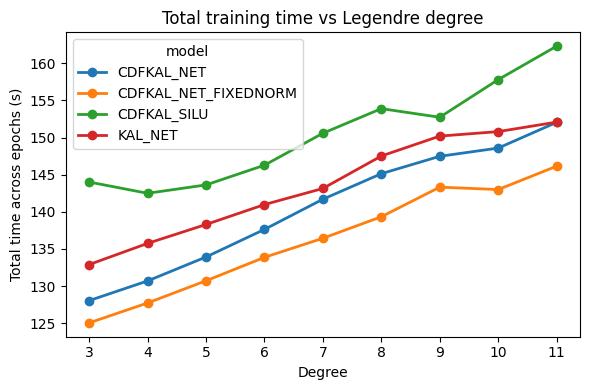

In [15]:
# --- imports ---
import pandas as pd
import matplotlib.pyplot as plt


time_tot = (
    combined_without_double_silu.groupby(['model', 'degree'], as_index=False)['epoch_time']
      .sum()
      .sort_values(['model', 'degree'])
)

plt.figure(figsize=(6, 4))
for model, grp in time_tot.groupby('model'):
    plt.plot(grp['degree'], grp['epoch_time'],
             marker='o', linewidth=2, label=model)

plt.title('Total training time vs Legendre degree')
plt.xlabel('Degree')
plt.ylabel('Total time across epochs (s)')
plt.legend(title='model')
plt.tight_layout()
plt.show()


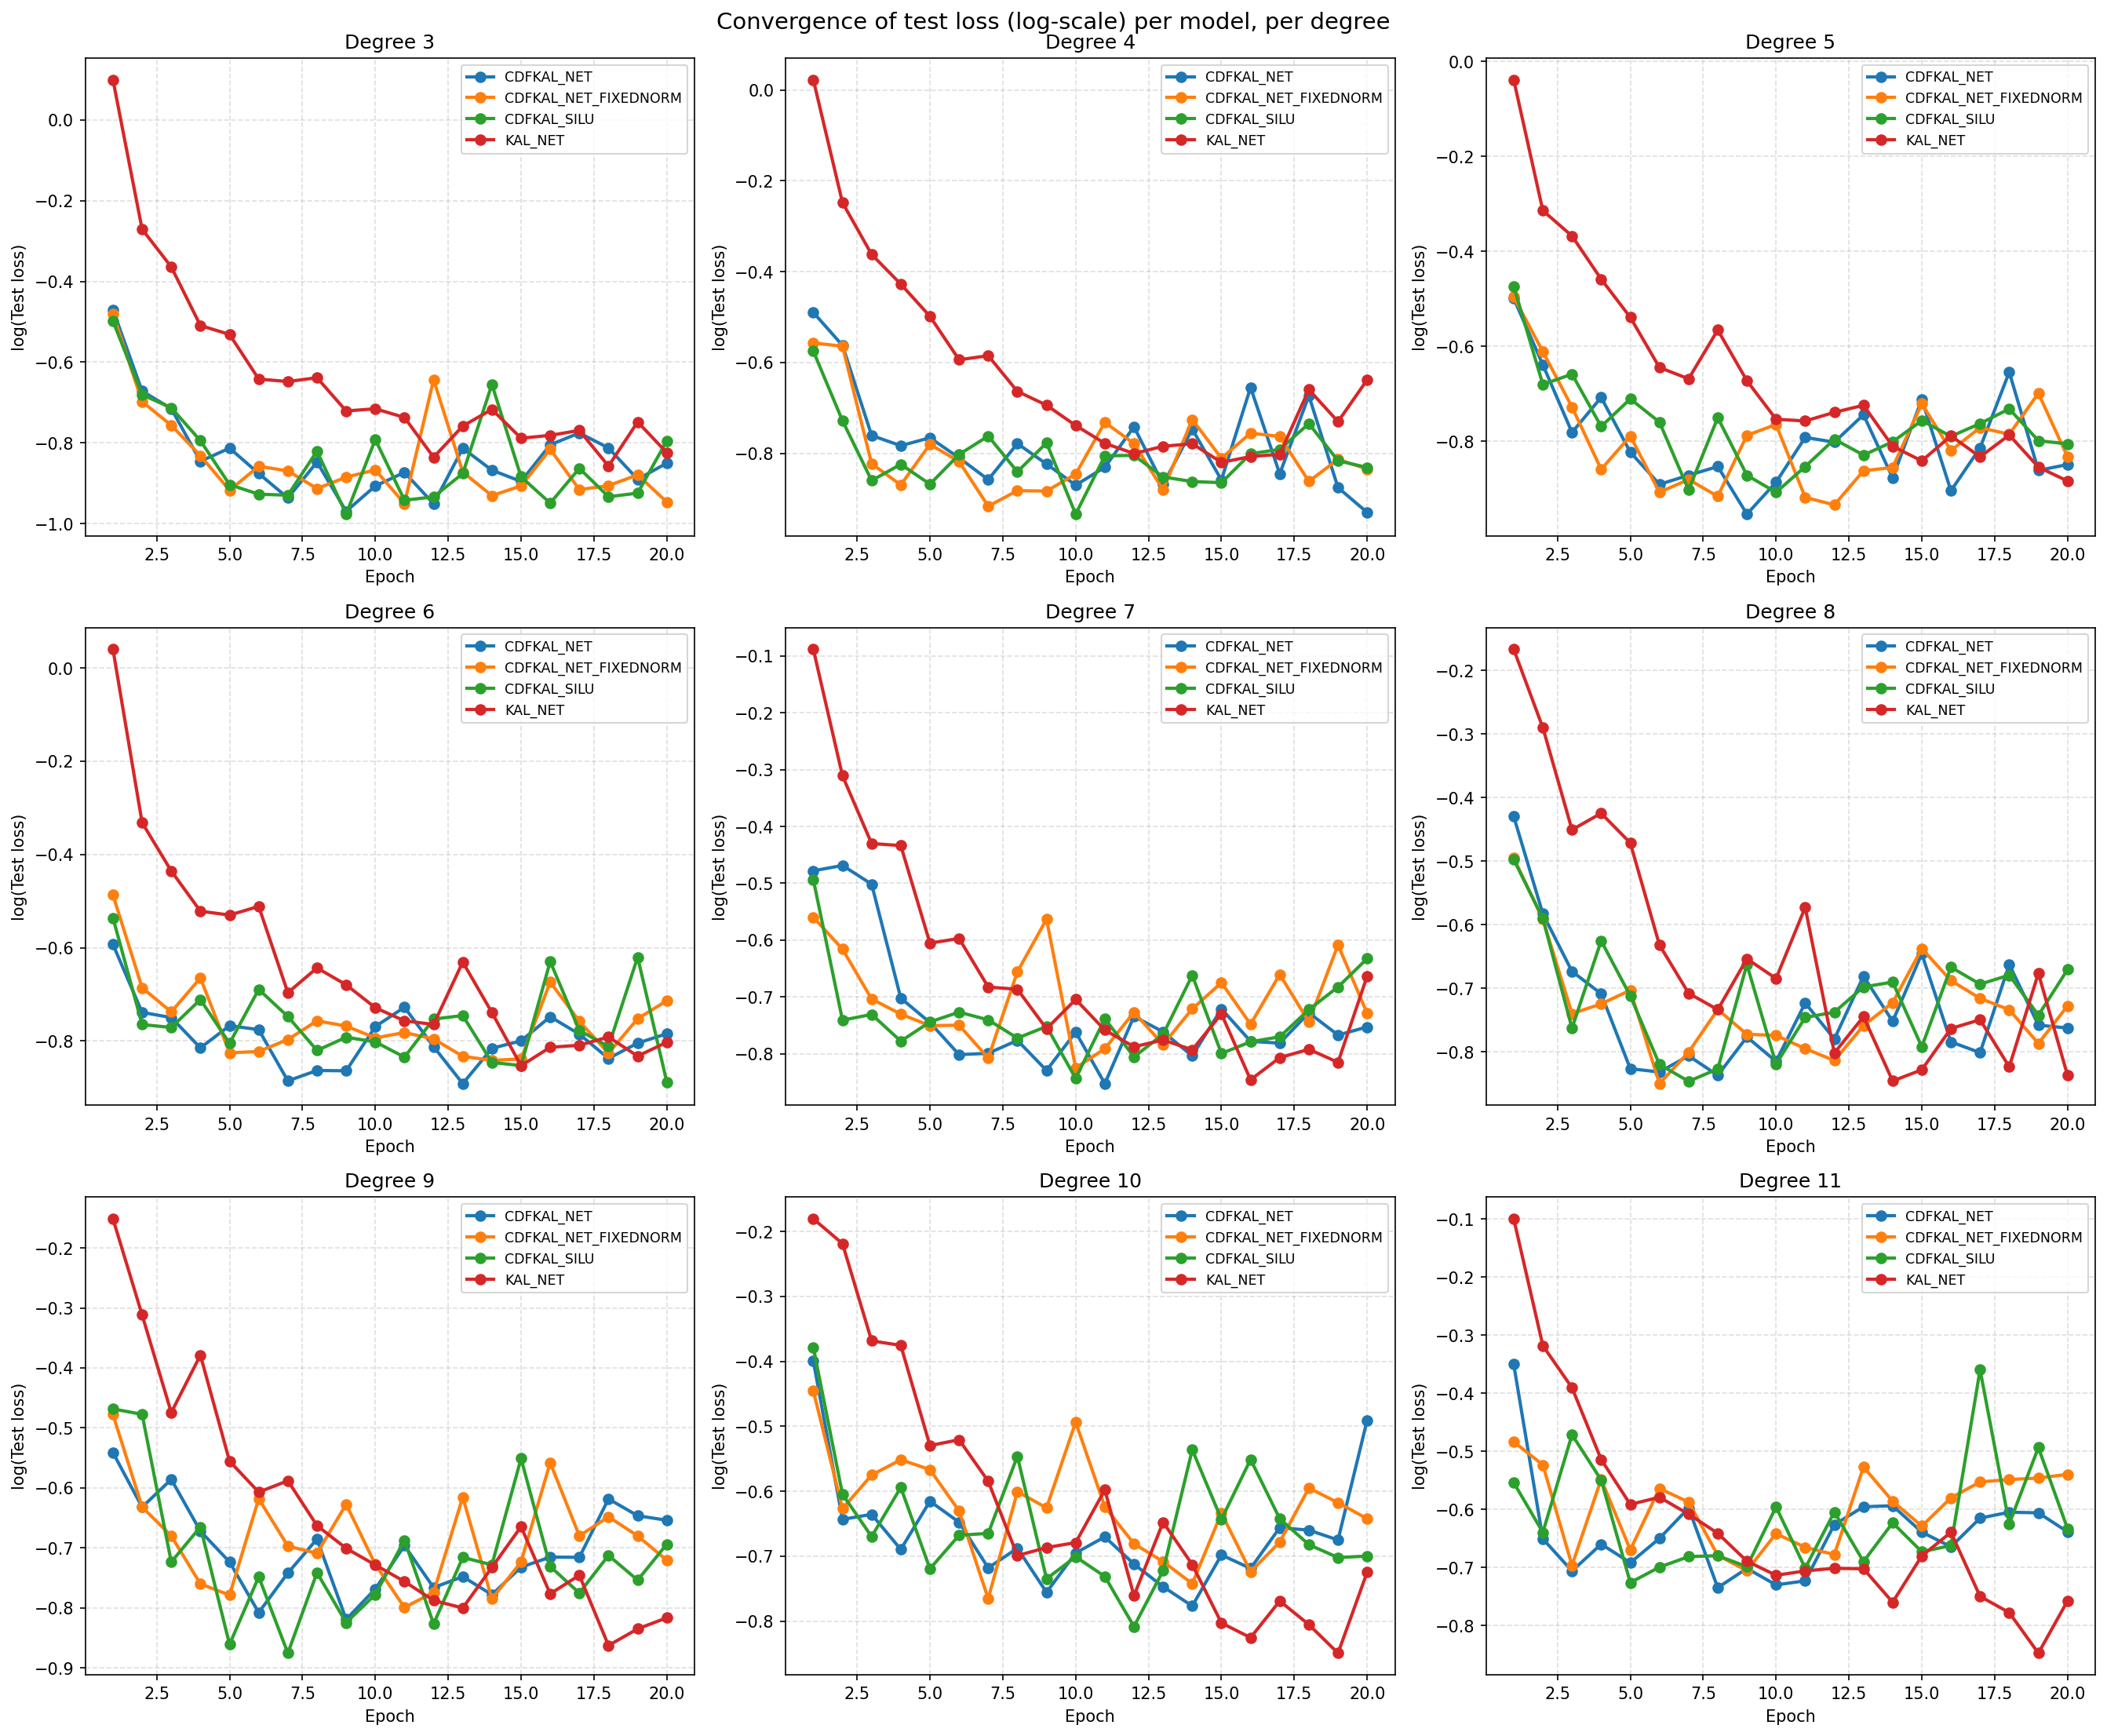

In [21]:
# ---------------------------------------------------------------
#  LOG-SCALE CONVERGENCE OF TEST LOSS  (one subplot per degree)
# ---------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt

df10 = combined_without_double_silu.copy()

degrees = sorted(df10['degree'].unique())
ncols = 3
nrows = int(np.ceil(len(degrees) / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 6, nrows * 5), sharex=False, sharey=False)
axes = axes.flatten()
plt.rcParams['figure.dpi'] = 150

for ax, deg in zip(axes, degrees):
    dsub = df10[df10['degree'] == deg]
    for model, grp in dsub.groupby('model'):
        ax.plot(
            grp['epoch'],
            np.log10(grp['test_loss']),   # log10 so the axis is linear but values are log
            marker='o',
            linewidth=2,
            label=model,
        )
    ax.set_title(f'Degree {deg}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('log(Test loss)')
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.legend(title=None, fontsize='small')

# remove any empty subplot frames (if degrees % 3 != 0)
for i in range(len(degrees), len(axes)):
    fig.delaxes(axes[i])

fig.suptitle('Convergence of test loss (log-scale) per model, per degree', fontsize=14)
plt.tight_layout()
plt.show()


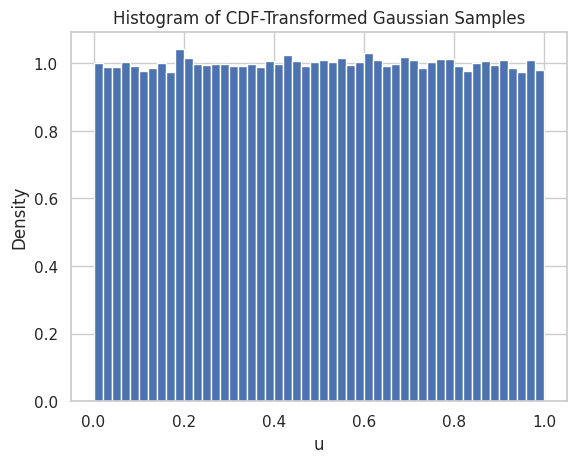

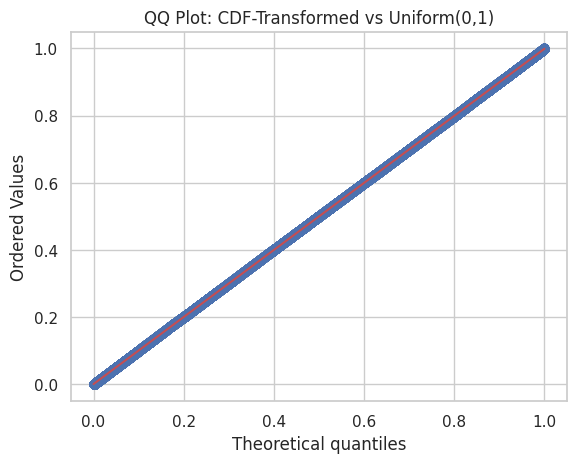

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
import scipy.stats as stats

x = np.random.randn(200000) #this is what layernorm does
u = 0.5 * (1 + erf(x / np.sqrt(2))) #cdf

plt.figure()
plt.hist(u, bins=50, density=True)
plt.title('Histogram of CDF-Transformed Gaussian Samples')
plt.xlabel('u')
plt.ylabel('Density')
plt.show()

plt.figure()
stats.probplot(u, dist='uniform', sparams=(0, 1), plot=plt)
plt.title('QQ Plot: CDF-Transformed vs Uniform(0,1)')
plt.show()


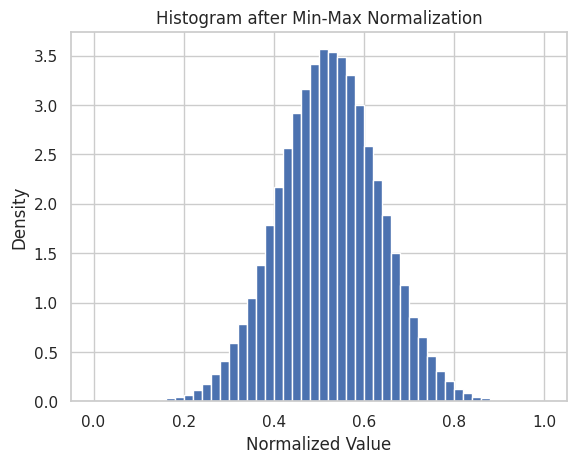

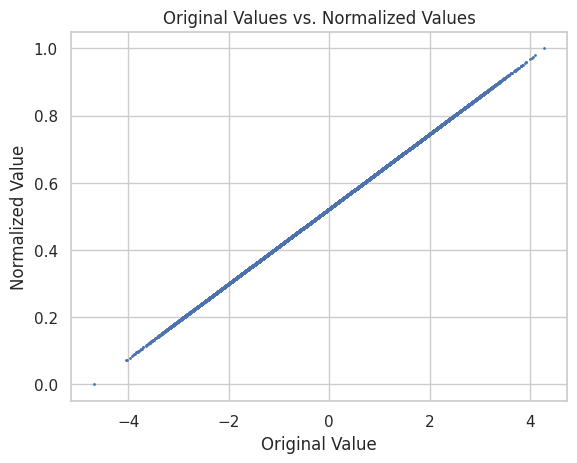

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


x = np.random.randn(200000)
x_min, x_max = x.min(), x.max()
x_norm = (x - x_min) / (x_max - x_min)


plt.figure()
plt.hist(x_norm, bins=50, density=True)
plt.title('Histogram after Min-Max Normalization')
plt.xlabel('Normalized Value')
plt.ylabel('Density')
plt.show()

plt.figure()
plt.scatter(x, x_norm, s=1)
plt.title('Original Values vs. Normalized Values')
plt.xlabel('Original Value')
plt.ylabel('Normalized Value')
plt.show()


100%|██████████| 4.54k/4.54k [00:00<00:00, 9.04MB/s]


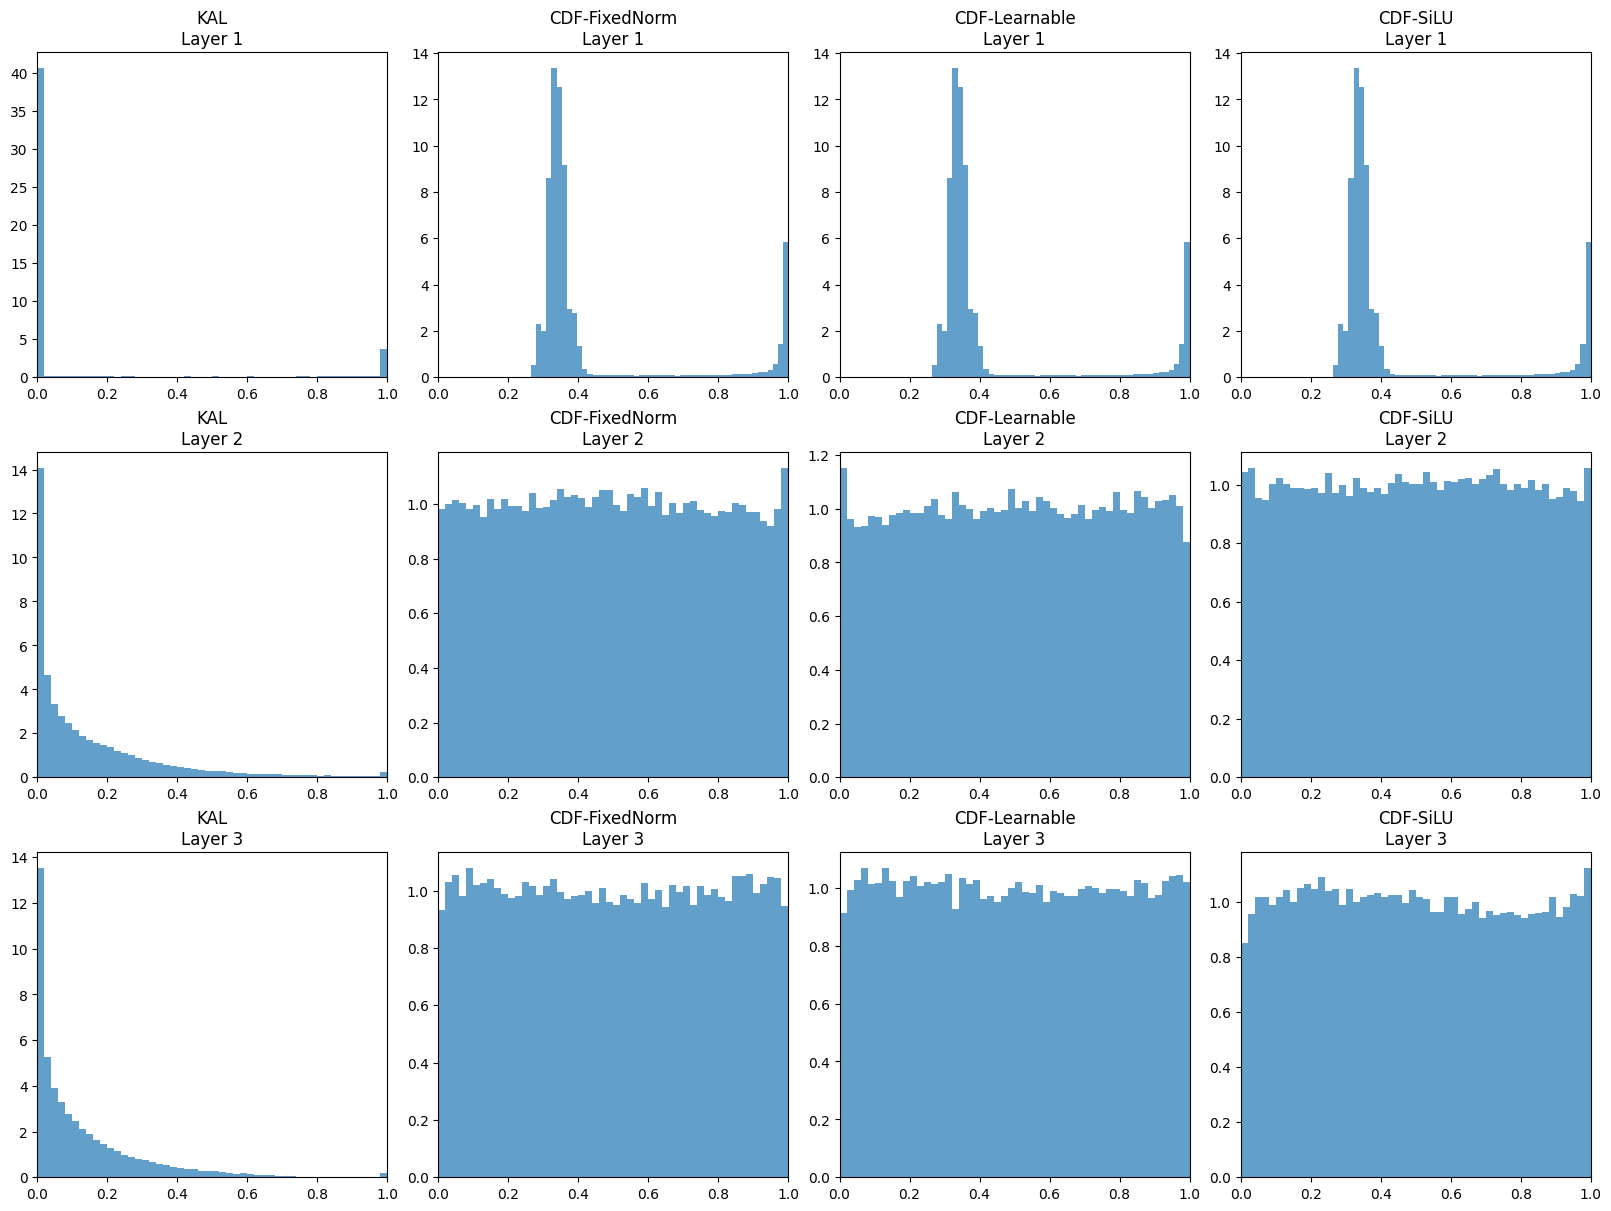

In [7]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
class CDFKAL_SINGLE_SILU_Layer(nn.Module):
    def __init__(self, in_f, out_f, degree, act=nn.SiLU):
        super().__init__()
        self.act = act()
        self.degree = degree

        self.base_w = nn.Parameter(torch.empty(out_f, in_f))
        self.poly_w = nn.Parameter(torch.empty(out_f, in_f * (degree + 1)))

        #initialize paarams
        nn.init.kaiming_uniform_(self.poly_w, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.base_w, a=math.sqrt(5))

    def forward(self, x):
        z = self.act(F.linear(x, self.base_w)) #single silu activation
        u = 0.5 * (1 + torch.erf(x / math.sqrt(2)))
        P = compute_scaled_legendre_polynomials(u, self.degree).view(x.size(0), -1)
        z += F.linear(P, self.poly_w)
        return z

class CDFKAL_NET_SILU1(nn.Module):
    "This is CDF-Normalized KAN with Legendre Basis with learnable beta and gamma in the LayerNorm with Silu"
    def __init__(self, degree):
        super().__init__()
        self.ln0 = nn.LayerNorm(28*28)
        self.l1  = CDFKAL_SINGLE_SILU_Layer(28*28, 256, degree)
        self.ln1 = nn.LayerNorm(256)
        self.l2  = CDFKAL_SINGLE_SILU_Layer(256, 256, degree)
        self.ln2 = nn.LayerNorm(256)
        self.l3  = CDFKAL_SINGLE_SILU_Layer(256, 10,  degree)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.ln0(x)
        x = self.l1(x)
        x = self.ln1(x)
        x = self.l2(x)
        x = self.ln2(x)
        return self.l3(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.ToTensor(),
])
mnist = MNIST(root='./data', train=False, download=True, transform=transform)
loader = DataLoader(mnist, batch_size=256, shuffle=True)



degree = 5

models = {
    'KAL':           KAL_NET(degree).to(device),
    'CDF‑FixedNorm': CDFKAL_NET_FIXEDNORM(degree).to(device),
    'CDF‑Learnable': CDFKAL_NET(degree).to(device),
    'CDF‑SiLU':      CDFKAL_NET_SILU1(degree).to(device),   # ← new line
}

# initialize storage for hooks (unchanged)
norm_data = {
    name: {0: [], 1: [], 2: []}
    for name in models
}

def make_hook(model_name, layer_idx, mode):
    def hook(module, inp, outp):
        x = inp[0]
        if mode == 'x_n':
            mn  = x.amin(dim=1, keepdim=True)
            mx  = x.amax(dim=1, keepdim=True)
            x_n = (x - mn) / (mx - mn + 1e-6)
            norm_data[model_name][layer_idx].append(x_n.detach().cpu().view(-1))
        else:
            u = 0.5 * (1 + torch.erf(x / math.sqrt(2)))
            norm_data[model_name][layer_idx].append(u.detach().cpu().view(-1))
    return hook

# register hooks (mode='x_n' for KAL, 'u' for all CDF‐variants)
for name, net in models.items():
    for idx, lname in enumerate(['l1','l2','l3']):
        layer = getattr(net, lname)
        mode  = 'x_n' if name == 'KAL' else 'u'
        layer.register_forward_hook(make_hook(name, idx, mode))

# run one batch through each net
batch, _ = next(iter(loader))
batch      = batch.to(device)
for net in models.values():
    net.eval()
    with torch.no_grad():
        net(batch)

# ─── Update the plotting code to handle 4 columns ──────────────────────────────

fig, axes = plt.subplots(3, 4, figsize=(16, 12), constrained_layout=True)
model_names = list(models.keys())

for col, name in enumerate(model_names):
    for row in range(3):
        data = torch.cat(norm_data[name][row]).numpy()
        axes[row, col].hist(data, bins=50, density=True, alpha=0.7)
        axes[row, col].set_title(f'{name}\nLayer {row+1}')
        axes[row, col].set_xlim(0, 1)
        axes[row, col].set_ylim(0, None)

plt.show()
